## Construct Your Own GSA-Net

In this notebook, we illustrate the construction of a simple Group Self-Attention Network (GSA-Net), proposed in our work [Group Equivariant Stand-Alone Self-Attention For Vision](https://openreview.net/forum?id=JkfYjnOEo6M). The code provided here is a simplified version of the main code. For baseline comparisons, please refer to the main code.

In particular, we will:
* Use the `g_selfatt` library to construct a GSA-Net

**Note:** If you are interested in visualizing the behaviour of the group self-attention and lifting self-attention layers, please refer to the complementary files in this repository.

Lets go! First, we import some packages:

In [1]:
# Append .. to path
import os,sys
g_selfatt_source =  os.path.join(os.getcwd(), '..')
if g_selfatt_source not in sys.path:
    sys.path.append(g_selfatt_source)
    
import numpy as np
import torch
import torch.nn as nn

import g_selfatt
from g_selfatt.nn import (
    Conv3d1x1,
    GroupLocalSelfAttention,
    GroupSelfAttention,
    LayerNorm,
    LiftLocalSelfAttention,
    LiftSelfAttention,
    TransformerBlock,
    activations,
)

from matplotlib import pyplot as plt

### Lifting and Group Self-Attention

First recall how to construct a lifting and a group self-attention layer. These layers have the following init signature:

```
LiftLocalSelfAttention(
    group: g_selfatt.groups.group.Group,
    in_channels: int,
    mid_channels: int,
    out_channels: int,
    num_heads: int,
    patch_size: int,
    attention_dropout_rate: float,
)
```

```
GroupLocalSelfAttention(
    group: g_selfatt.groups.group.Group,
    in_channels: int,
    mid_channels: int,
    out_channels: int,
    num_heads: int,
    patch_size: int,
    attention_dropout_rate: float,
)
```
```
Args:
    group: The group to be used, e.g., rotations.
    in_channels:  Number of channels in the input signal
    mid_channels: Number of channels of the hidden representation on which attention is performed.
    out_channels: Number of channels in the output signal
    num_heads: Number of heads in the operation
    max_pos_embedding: The maximum size of the positional embedding to use.
    patch_size: The maximum size of the positional embedding to use.
    attention_dropout_rate: Dropout applied to the resulting attention coefficients.
```

**Note:** In this demo, we use Local self-attention. However, the entire procedure performed here can be replicated for global self attention by changing the layers `LiftLocalSelfAttention` and `GroupLocalSelfAttention` by `LiftSelfAttention` and `GroupSelfAttention`, respectively.

In [2]:
#Example:
group = g_selfatt.groups.E2(num_elements=16) # The group of rotations by 45 degrees and mirroring.
in_channels = 1
out_channels = 12
mid_channels = out_channels // 2
num_heads = 9
patch_size = 5
attention_dropout_rate = 0.1

attention_layer = GroupLocalSelfAttention(group,
                                       in_channels,
                                       mid_channels,
                                       out_channels,
                                       num_heads,
                                       patch_size,
                                       attention_dropout_rate)

### Transformer Block

Now, we construct a `TransformerBlock` that follows the structure shown in the following image:

<img src="../block_structure.png " width=480 />

The `TransformerBlock` class has the following init signature:

```
Init signature:
TransformerBlock(
    in_channels: int,
    out_channels: int,
    attention_layer: torch.nn.modules.module.Module,
    norm_type: str,
    activation_function: str,
    crop_size: int,
    value_dropout_rate: float,
    dim_mlp_conv: int,
)

Args:
    in_channels: Number of channels in the input signal
    out_channels: Number of output (and hidden) channels of the block
    attention_layer: The type of attention layer to be used, e.g., lifting or group self-attention.
    norm_type: The normalization type to use, e.g., LayerNorm.
    activation_function: The activation function of the block, e.g., ReLU
    crop_size: How much must be cropped at each side of the output.
    value_dropout_rate: Dropout on the resulting representation of the self-attention layer.
    dim_mlp_conv: The dimensionality of the MLP to use, e.g., 2 for spatial signal, 3 for group signal.

```


In [3]:
# Example:
in_channels = 1
out_channels = 12
attention_layer = attention_layer # (Defined above)
norm_type = "LayerNorm"
activation_function = "Swish"
crop_size = 0
value_dropout_rate = 0.1
dim_mlp_conv = 3

attention_block = TransformerBlock(in_channels,
                                  out_channels,
                                  attention_layer,
                                  norm_type,
                                  activation_function,
                                  crop_size,
                                  value_dropout_rate,
                                  dim_mlp_conv)

#### Group Self-Attention Network (GSA-Net)

In order to construct a GSA-Net, we first construct a `GSANet_Backbone`, which implements a group self-attention network composed of a `LiftLocalSelfAttention` layer with proper normalization and activation layers, followed by `num_blocks` `TransformerBlocks`. In other words, a network without the final `Linear` and `GlobalPooling` layers as illustrated in the figure above. 

##### GSANet_backbone

In [4]:
class GSANet_backbone(torch.nn.Module):
    def __init__(
        self,
        group: g_selfatt.groups.Group,
        in_channels: int,
        hidden_channels: int,
        num_heads: int,
        num_blocks: int,
        attention_type: str,
        patch_size: int,  # Patch size if local, Image Size if global
        attention_dropout_rate: float,
        values_dropout_rate: float,
        crop_size: float,
    ):
        super().__init__()
        
        # Define the normalization layer type 
        Norm = g_selfatt.nn.LayerNorm
        
        # Define the activation function type
        Activation = g_selfatt.nn.activations.Swish
        
        # Define which kind of self-attention to use (global or local)
        if attention_type == 'Local':
            liftingSA = LiftLocalSelfAttention
            groupSA = GroupLocalSelfAttention
        elif attention_type == 'Global':
            liftingSA = LiftSelfAttention
            groupSA = GroupSelfAttention
        else:
            raise ValueError("Unexpected value for attention type: {}".format(attention_type))
            

        # -------------- Layers ---------------------------
        
        # Lifting self-att layer.
        self.lifting = liftingSA(group,
                                 in_channels,
                                 hidden_channels // 2,
                                 hidden_channels,
                                 num_heads,
                                 patch_size,
                                 attention_dropout_rate,                                                            
                                )
        
        # Define norm after lifting
        self.lift_norm = Norm(hidden_channels)
        
        # Define activation
        self.lift_activ = Activation()
        
        # Attention blocks:
        blocks = []
        for i in range(num_blocks):
            blocks.append(
                g_selfatt.nn.TransformerBlock(
                    hidden_channels,
                    hidden_channels,
                    groupSA(group,
                            hidden_channels,
                            hidden_channels // 2,
                            hidden_channels,
                            num_heads,
                            patch_size,
                            attention_dropout_rate,
                           ),
                    "LayerNorm",
                    "Swish",
                    crop_size,
                    value_dropout_rate,
                    dim_mlp_conv = 3,
                )
            )
        self.attention_blocks = torch.nn.Sequential(*blocks)
        
        # -----------------------------------------------
        
    # We initialize the network in the GSANet class below.
    def initialize_network(self, whitening_scale):
        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(
                    0,
                    whitening_scale
                    * torch.prod(torch.Tensor(list(m.weight.shape)[1:])) ** (-1 / 2),
                )
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
        
    def _forward(self, x):
        out = self.lift_activ(self.lift_norm(self.lifting(x)))
        out = self.attention_blocks(out)
        return out
    
    def forward(self, x):
        return self._forward(x)

As an example, we may create a GSA_backbone network with a lifting layer, and 2 TransformerBlocks as specified below:

In [5]:
# Parameters:
group = g_selfatt.groups.E2(num_elements=16) # The group of rotations by 45 degrees and mirroring.
in_channels = 1
hidden_channels = 12
num_heads = 9
num_blocks = 2
attention_type = "Local"
patch_size = 5
attention_dropout_rate = 0.1
values_dropout_rate = 0.1
crop_size = 0

net = GSANet_backbone(group,
                     in_channels,
                     hidden_channels,
                     num_heads,
                     num_blocks,
                     attention_type,
                     patch_size,
                     attention_dropout_rate,
                     values_dropout_rate,
                     crop_size,
                     )

##### GSA-Net

In [6]:
class GSANet(GSANet_backbone):
    def __init__(
        self,
        group: g_selfatt.groups.Group,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_heads: int,
        num_blocks: int,
        attention_type: str,
        patch_size: int,  # Patch size if local, Image Size if global
        attention_dropout_rate: float,
        values_dropout_rate: float,
        crop_size: float,
        whitening_scale: float,
    ):
        super().__init__(
            group,
            in_channels,
            hidden_channels,
            num_heads,
            num_blocks,
            attention_type,
            patch_size,
            attention_dropout_rate,
            values_dropout_rate,
            crop_size,
        )
        
        # Final layer:
        self.finallyr = g_selfatt.nn.Conv3d1x1(hidden_channels, out_channels)
        
        # Initialize network
        self.initialize_network(whitening_scale)
         
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Pass the network through the GSANet backbone
        out = self._forward(x)
        # And then after the last layer
        out = self.finallyr(out)
        
        # Then perform global pooling and return output:
        # Out has form [batch_size, out_channels, group_dim, x, y]. Global Pooling is performed as:
        # 1. Sum over the spatial dimensions x, y.
        # 2. Max-pool over group dimension group_dim.
        return out.sum(dim=(-2, -1)).max(-1).values.view(batch_size, -1)        

In [7]:
# Construct network:

group = g_selfatt.groups.E2(num_elements=16) # The group of rotations by 45 degrees and mirroring.
in_channels = 1
hidden_channels = 12
out_channels = 4
num_heads = 9
num_blocks = 2
attention_type = "Local"
patch_size = 5
attention_dropout_rate = 0.0
values_dropout_rate = 0.0
crop_size = 0
whitening_scale = 1

net = GSANet(group,
             in_channels,
             hidden_channels,
             out_channels,
             num_heads,
             num_blocks,
             attention_type,
             patch_size,
             attention_dropout_rate,
             values_dropout_rate,
             crop_size,
             whitening_scale,
             )

net

GSANet(
  (lifting): LiftLocalSelfAttention(
    (group): E2()
    (row_embedding): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): LayerNorm(
        (layer_norm): GroupNorm(1, 16, eps=1e-12, affine=True)
      )
      (2): Swish()
      (3): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
    )
    (col_embedding): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): LayerNorm(
        (layer_norm): GroupNorm(1, 16, eps=1e-12, affine=True)
      )
      (2): Swish()
      (3): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
    )
    (query): Conv2d(1, 54, kernel_size=(1, 1), stride=(1, 1))
    (key): Conv2d(1, 54, kernel_size=(1, 1), stride=(1, 1))
    (value): Conv2d(1, 54, kernel_size=(1, 1), stride=(1, 1))
    (wout): Conv3d(54, 12, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (unfold): Unfold(kernel_size=(5, 5), dilation=1, padding=(2, 2), stride=1)
    (dropout_attention): Dropout(p=0.0, inplace=False)
  )
  (li

Voila! We have constructed a GSA-Net with 4 output channels (Image a 4-classes classification problem). 

We let now an in_signal go through the network:

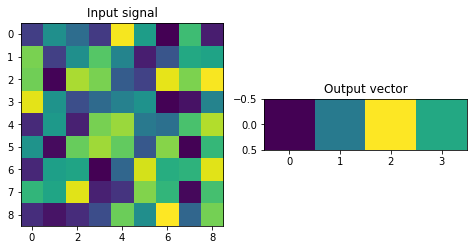

In [8]:
# 
batch_size = 2
in_channels = 1
x_dim = 9
y_dim = 9
in_signal = torch.rand([batch_size, in_channels, x_dim, y_dim])

out = net(in_signal)

# Plot input image n output vector
f,axs = plt.subplots(1,2,figsize=(8,6))
axs[0].set_title("Input signal")
axs[0].imshow(in_signal.numpy()[0, 0,:, :])
axs[1].set_title("Output vector")
axs[1].imshow(out.unsqueeze(-1).transpose(1,2).detach().numpy()[0, :])
plt.show()

Now, we can experiment with the network by rotating or mirroring the input signal. Due to the final global pooling, the network should be invariant to the group, and thus, its answer should not change.

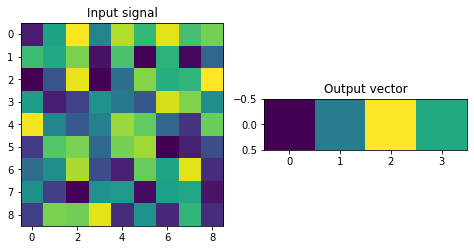

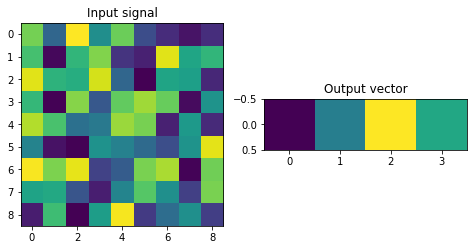

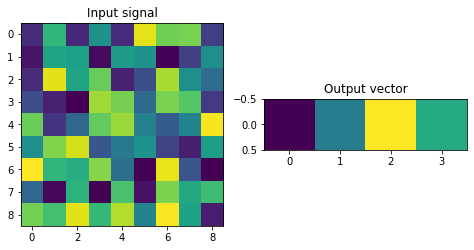

In [9]:
# Rotate by 90 degrees
for i in range(1, 4):
    in_signal_modif = torch.rot90(in_signal,
                                  k = i, # The number of times to rotate by 90 degrees
                                  dims = [-2, -1],
                                 )
    out = net(in_signal_modif)
    
    # Plot input image n output vector    
    f,axs = plt.subplots(1,2,figsize=(8,6))
    axs[0].set_title("Input signal")
    axs[0].imshow(in_signal_modif.numpy()[0, 0,:, :])
    axs[1].set_title("Output vector")
    axs[1].imshow(out.unsqueeze(-1).transpose(1,2).detach().numpy()[0, :])
    plt.show()

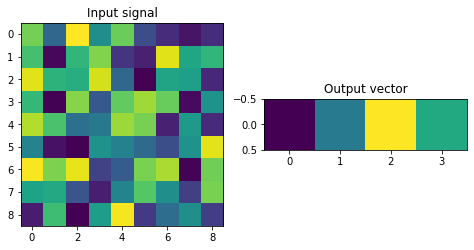

In [10]:
# Mirror it
in_signal_modif = torch.flip(in_signal, dims = [-2, -1])
out = net(in_signal_modif)

# Plot input image n output vector
f,axs = plt.subplots(1,2,figsize=(8,6))
axs[0].set_title("Input signal")
axs[0].imshow(in_signal_modif.numpy()[0, 0,:, :])
axs[1].set_title("Output vector")
axs[1].imshow(out.unsqueeze(-1).transpose(1,2).detach().numpy()[0, :])
plt.show()